# [E-12] News Summarize

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


# Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print(data.iloc[68736]['headlines'])

Man offers gold garland worth Ã¢ÂÂ¹8.36cr to shrine in Andhra


In [4]:
# 전체 데이타 수
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


# Step 2. 데이터 전처리하기 (추상적 요약)

## 2.1 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 2.2 텍스트 정규화와 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

## 2.3 데이타 전처리

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [12]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


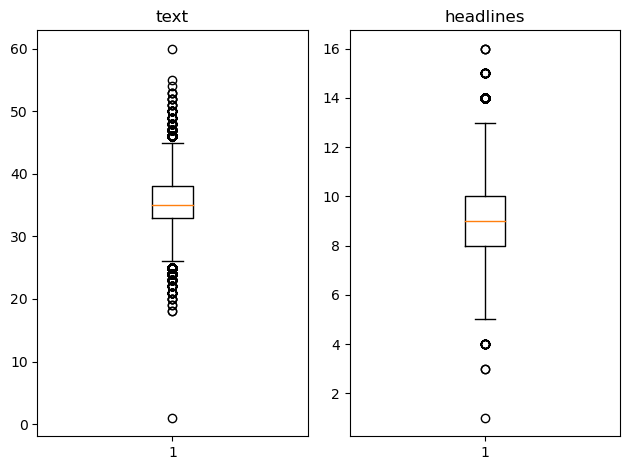

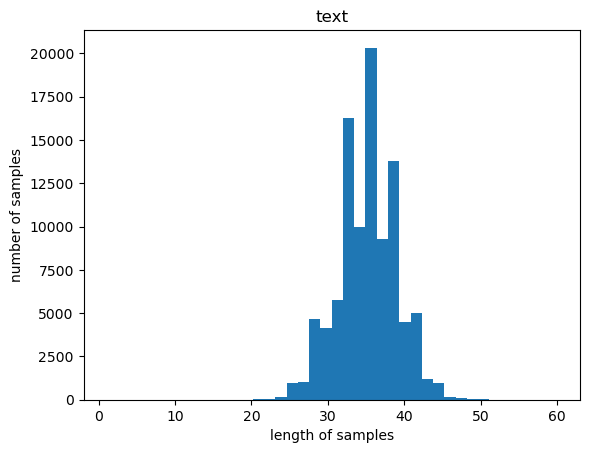

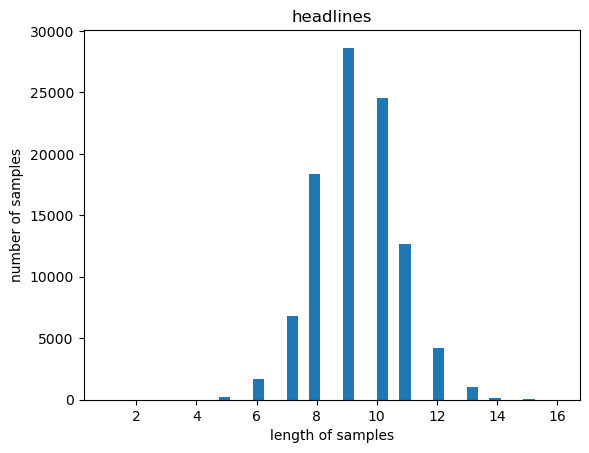

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 50
headlines_max_len = 12
print('=3')

=3


In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97169


In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[  554 83479  5844 ... 44306 39656 91085]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19433


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


## 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69273
등장 빈도가 6번 이하인 희귀 단어의 수: 47165
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22108
단어 집합에서 희귀 단어의 비율: 68.0856899513519
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.500064285549451


In [29]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[64, 250, 591, 10, 74, 12, 213, 3337, 3909, 968, 505, 287, 59, 53, 9, 10, 279, 6363, 4007, 11173, 3909, 968, 505, 869, 768, 2416, 2671, 968, 12, 52, 966, 968, 8346, 9, 4], [4998, 1692, 6025, 3010, 2087, 3608, 14145, 691, 3884, 4149, 6364, 111, 2794, 7236, 4999, 14683, 9237, 515, 82, 1722, 19362, 1333, 1136, 7863, 1430, 8774, 19, 302, 246, 4794, 1430, 12883, 515, 2365, 892, 1752, 1081, 655, 1446], [26, 20, 1244, 454, 80, 125, 1567, 1639, 7634, 1212, 43, 8627, 2584, 5242, 2679, 401, 246, 251, 20, 5242, 1610, 7237, 1167, 18, 77, 492, 105, 75, 346, 20, 476, 5242, 2306, 1213, 1343, 389]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29953
등장 빈도가 5번 이하인 희귀 단어의 수: 19584
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10369
단어 집합에서 희귀 단어의 비율: 65.38243247754816
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.708679695097086


In [33]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 125, 923, 1652, 10, 1432, 1775, 15, 353, 390], [1, 7193, 3648, 4, 4956, 2747, 1688, 4801, 3271, 9498], [1, 2748, 4957, 239, 1947, 2637, 17, 924, 152], [1, 137, 1994, 49, 277, 1689, 5, 9499, 2336, 1173], [1, 2806, 324, 1585, 2115, 1832, 156, 5, 12, 1887, 182]]
target
decoder  [[125, 923, 1652, 10, 1432, 1775, 15, 353, 390, 2], [7193, 3648, 4, 4956, 2747, 1688, 4801, 3271, 9498, 2], [2748, 4957, 239, 1947, 2637, 17, 924, 152, 2], [137, 1994, 49, 277, 1689, 5, 9499, 2336, 1173, 2], [2806, 324, 1585, 2115, 1832, 156, 5, 12, 1887, 182, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

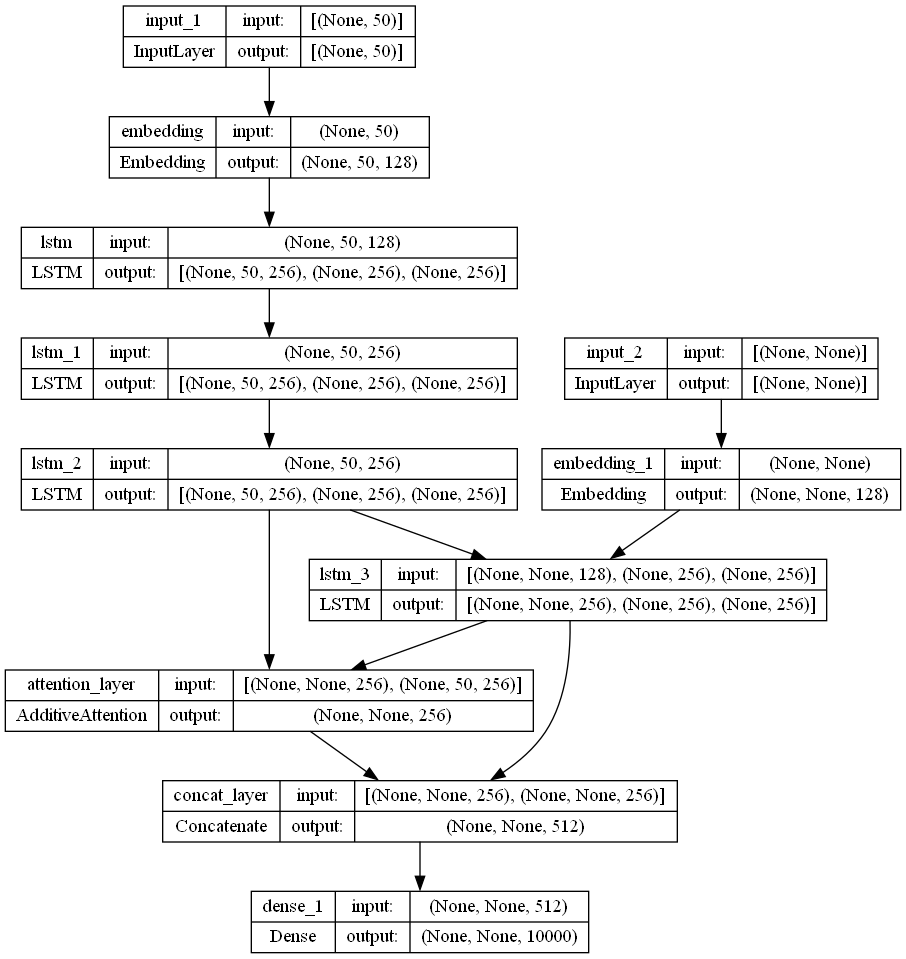

In [40]:
import keras.utils 
keras.utils.plot_model(model,'attention.png', show_shapes=True)

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 144s 447ms/step - loss: 5.6110 - val_loss: 5.1729
Epoch 2/50
304/304 [==============================] - 137s 450ms/step - loss: 5.0154 - val_loss: 4.7974
Epoch 3/50
304/304 [==============================] - 193s 637ms/step - loss: 4.6871 - val_loss: 4.5640
Epoch 4/50
304/304 [==============================] - 165s 542ms/step - loss: 4.4303 - val_loss: 4.3514
Epoch 5/50
304/304 [==============================] - 187s 617ms/step - loss: 4.2214 - val_loss: 4.2119
Epoch 6/50
304/304 [==============================] - 167s 548ms/step - loss: 4.0480 - val_loss: 4.1012
Epoch 7/50
304/304 [==============================] - 197s 650ms/step - loss: 3.8988 - val_loss: 4.0042
Epoch 8/50
304/304 [==============================] - 205s 673ms/step - loss: 3.7702 - val_loss: 3.9319
Epoch 9/50
304/304 [==============================] - 161s 529ms/step - loss: 3.6550 - val_loss: 3.8809
Epoch 10/50
304/304 [==============================] - 174s 572m

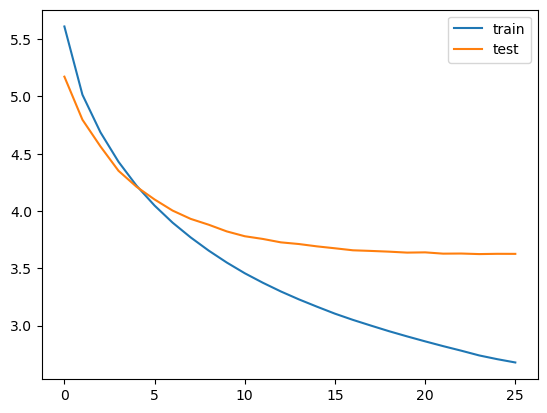

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- loss와 val_loss가 지속적으로 하락했다. 
- early stopping을 이용해서 과적합이 발생하기 전에 효과적으로 훈련을 중지시킬 수 있었다

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [195]:
for i in range(50,56):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian football team captain sunil chhetri became fourth best active international scorer world surpassing england wayne rooney th international goal chhetri goal helped india beat republic afc asian cup qualifier notably chhetri goals per match ratio better portugal captain cristiano ronaldo argentina captain lionel messi 
실제 요약 : chhetri passes rooney becomes th best active int scorer 
1/1 [==============================] - 0s 26ms/step
예측 요약 :  chhetri becomes world highest scorer scorer


원문 : danish amateur submarine inventor peter charged negligent manslaughter missing swedish journalist kim wall onboard vessel sank denmark east coast however contesting days detention denied role disappearance wall claimed dropped danish island 
실제 요약 : submarine inventor arrested over disappearance of journalist 
1/1 [==============================] - 0s 21ms/step
예측 요약 :  tourist who died in us after yrs of


원문 : mumbai witnessed slow traffic monday due heavy rains waterlogged roads city 

# Step 5. Summa을 이용해서 추출적 요약해보기

In [212]:
from summa.summarizer import summarize
from summa import keywords

In [230]:
#text = 'per reports madhuri dixit play role abhishek directorial kalank though madhuri also played film devdas character kalank said different portrayed earlier reportedly portray trained dancer teaches others dance form'
text = 'BJP MP Shatrughan Sinha on Thursday backed former Finance Minister Yashwant Sinha for criticising the BJP-led Centre, saying, "He has shown the mirror to the government on economic condition." "[E]verything written by Mr Sinha is entirely in the partys and national interest. Only recently our PM Narendra Modi has reiterated that the nation is bigger than the party," Shatrughan added.'
print('Summary:')
print(summarize(text, words=25))


Summary:
BJP MP Shatrughan Sinha on Thursday backed former Finance Minister Yashwant Sinha for criticising the BJP-led Centre, saying, "He has shown the mirror to the government on economic condition." "[E]verything written by Mr Sinha is entirely in the partys and national interest.


🧐 summa.summarizer를 이용해 Extractive Summarize(추출적 요약)를 하려면 전처리(. 마침표가 있는 문장 필요)를 하지 않은 문장을 넣어야 한다.    
- 그래서 아래와 같이 다시 CSV파일을 읽어 전처리 하지 전에 Data를 준비한다. 

In [ ]:
# 원본 데이타 가져오기
data_origin = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [235]:
#위에서 추상적 요약에서 사용한 데이타를 동일하게 추출적 요약에 사용하기 위해 탐색
seq2text(encoder_input_test[51])

'danish amateur submarine inventor peter charged negligent manslaughter missing swedish journalist kim wall onboard vessel sank denmark east coast however contesting days detention denied role disappearance wall claimed dropped danish island '

In [254]:
# 추상적 요약에서 사용했던 데이타를 찾는다. 
print(data_origin[data_origin['headlines'].str.startswith('Submarine')]['text'])
#print(data_origin[data_origin['headlines'].str.startswith('Chhetri')]['headlines'])

75161    Danish amateur submarine inventor Peter Madsen...
Name: text, dtype: object


In [231]:
print(data_origin.iloc[75161]['text'])

Danish amateur submarine inventor Peter Madsen has been charged with negligent manslaughter of missing Swedish journalist Kim Wall who had been onboard his vessel before it sank off Denmark's east coast. However, Madsen who is not contesting his 24-days detention has denied any role in disappearance of Wall and claimed that he had dropped her off on a Danish island.


In [252]:
# 대상 데이타를 가지고 추출적 요약 
for i in [84995,75161,80081,97202,68203,78243] :    
    print("추출적 요약 :", summarize(data_origin['text'][i], words=25))
    print("키워드 :", keywords.keywords(data_origin['text'][i]))
    print("\n")

추출적 요약 : Notably, Chhetri's goals per match ratio of 0.57 is better than Portugal captain Cristiano Ronaldo and Argentina captain Lionel Messi.
키워드 : captain
international
surpassing
goal
goals
chhetri
kyrgyz
asian


추출적 요약 : Danish amateur submarine inventor Peter Madsen has been charged with negligent manslaughter of missing Swedish journalist Kim Wall who had been onboard his vessel before it sank off Denmark's east coast.
키워드 : peter
danish amateur


추출적 요약 : Mumbai witnessed slow traffic on Monday due to heavy rains and waterlogged roads.
Meanwhile, local train services were also disrupted early morning but resumed later as the day progressed.
키워드 : mumbai witnessed slow traffic


추출적 요약 : Bihar CM Nitish Kumar released the state's startup policy at the Bihar Entrepreneurship Summit on Tuesday.
키워드 : entrepreneurship
kumar
startup
fund
funding


추출적 요약 : This makes him at least the 12th former SAP executive to have left Infosys since March 2016.
키워드 : infosys
vice
senior
denied




# Step 6. 추상적요약과 추출적 요약 비교 분석

<img src='https://user-images.githubusercontent.com/95423215/236160066-25544ca1-09a2-4622-82df-f0bf61a10aee.png' width='80%' height='80%'>
<img src='https://user-images.githubusercontent.com/95423215/236160070-a7db445c-6fdc-40a6-a05a-b04d4ea2bde8.png' width='80%' height='80%'>
<img src='https://user-images.githubusercontent.com/95423215/236160072-8d5d8e34-65f9-4485-8ef5-cadaf3bb038b.png' width='80%' height='80%'>
<img src='https://user-images.githubusercontent.com/95423215/236160074-23239d93-233c-498e-ba98-ab563eec160a.png' width='80%' height='80%'>
<img src='https://user-images.githubusercontent.com/95423215/236160078-098152bc-028c-4c73-ba63-be8688c59299.png' width='80%' height='80%'>
<img src='https://user-images.githubusercontent.com/95423215/236160081-5b6841ae-9d14-45b6-b757-f8038e61b990.png' width='80%' height='80%'>

- 문장 완성도 측면에서 추상적 요약이 잘 된 경우(50, 52, 53,54)도 있었지만, 전혀 의미도 맞지 않고 형편 없는 경우(51,55)도 있어 편차가 높은 편이다. 
- 반면에 추출적 요약은 문장 중에서 1~2문장을 가져와서 문장의 완성도는 높은 편이나 54번과 같이 핵심내용을 벗어난 문장을 요약한 경우도 있다.
- 핵심단어 포함 측면에서 추상적 요약은 문장 완성도가 높은 경우(50, 52, 53,54)는 핵심단어도 비교적 잘 포함하고 있지만, 문장 완성도가 높지 않은 (51,54)경우는 단순한 단어의 나열처럼 핵심 단어를 포함하지 않고 있다.
- 추출적 요약에서는 대체로 핵심단어를 잘 포함했지만, 50,53,54의 경우는 내용이 핵심단어를 포함하지 못하고, 포함했더라도 전체적인 문장이 핵심을 빗겨간 경우가 보였다.   

# 회고

- Attantion layer를 사용해서 추상적 요약을 작성하며, 기존 RNN과의 차이를 구체적으로 이해할 수 있었다. 
- 추상적 요약을 하던 원문 인덱스로 추출적 요약 로직을 호출했더니, 전혀 요약이 나오지 않아 당황했었다.  
원인은 Summa에서 데이타 요약을 하기 위해서는 전처리 되지 않은 내용으로 호출해야 한다는 것을 알았다. 
- 추상적 요약에서 쓰이는 인덱스를 그대로 추출적 요약의 데이타를 호출할 경우 엉뚱한 단어들이 요약되어 나오는 것을 알았다. 
원인은 추상적 요약에서 shuffle로 인덱스를 섞어주었던 것이 생각나서 추상적 요약에 내용을 원문에서 찾아내서 인덱스를 가져와 검색했다. 
- 당연히 단순히 For문으로 Summa를 호출해서 추출적 요약이 나올 줄 알았는데 인덱스가 맞지 않아 당황했지만, 그래도 해결했다.  

## 참고 문헌

https://radimrehurek.com/gensim_3.8.3/summarization/summariser.html   
http://www.taln.upf.edu/pages/summa.upf/processing_resources.html   
   
https://www.apple.com/newsroom/2023/04/apple-expands-innovative-restore-fund-for-carbon-removal/